In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection

## Correlation based

In [39]:
data_engineered = pd.read_csv('data/data_cleaned_engineered.csv')
data_engineered.set_index('PUF_ID', inplace=True)
data_engineered

,sample,fpl,FWBscore,FSscore,SUBKNOWL1,FINGOALS,SAVEHABIT,FRUGALITY,AUTOMATED_1,AUTOMATED_2,...,finalwt,SWB,ACT,PROPPLAN,MANAGE,MATHARDSHIP,FINSOC,MATERIALISM,SELFCONTROL,OUTLOOK
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,55.0,44.0,5.0,1.0,4.0,6.0,0.0,0.0,...,0.367292,5.0,4.0,4.0,4.0,1.0,6.0,4.0,3.0,2.0
7740,1,3,51.0,43.0,5.0,0.0,1.0,5.0,0.0,0.0,...,1.327561,6.0,4.0,2.0,3.0,1.0,1.0,3.0,3.0,4.0
13699,1,3,49.0,42.0,5.0,1.0,5.0,5.0,1.0,1.0,...,0.835156,4.0,3.0,4.0,3.0,1.0,2.0,4.0,3.0,4.0
7375,1,3,49.0,42.0,4.0,1.0,4.0,4.0,0.0,1.0,...,4.260668,4.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0
10910,1,3,67.0,57.0,6.0,1.0,4.0,5.0,1.0,1.0,...,0.760061,6.0,4.0,4.0,4.0,1.0,5.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,3,2,44.0,45.0,5.0,1.0,5.0,6.0,0.0,0.0,...,2.563018,7.0,4.0,4.0,4.0,1.0,7.0,2.0,3.0,3.0
11220,3,3,61.0,47.0,5.0,1.0,4.0,5.0,0.0,1.0,...,0.522504,7.0,4.0,3.0,4.0,1.0,3.0,3.0,3.0,4.0
8709,1,3,59.0,51.0,4.0,1.0,5.0,5.0,1.0,1.0,...,1.136270,6.0,4.0,4.0,5.0,1.0,3.0,4.0,2.0,4.0


In [40]:
cat_feats = ['sample', 'FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2',
             'HOUSING', 'LIVINGARRANGEMENT', 'SNAP', 'FRAUD2',
             'COVERCOSTS', 'MANAGE2', 'RETIRE', 'generation',
             'PPETHM', 'PPMARIT', 'PPREG9']

num_feats = list(set(data_engineered.columns) - set(cat_feats))

<Axes: >

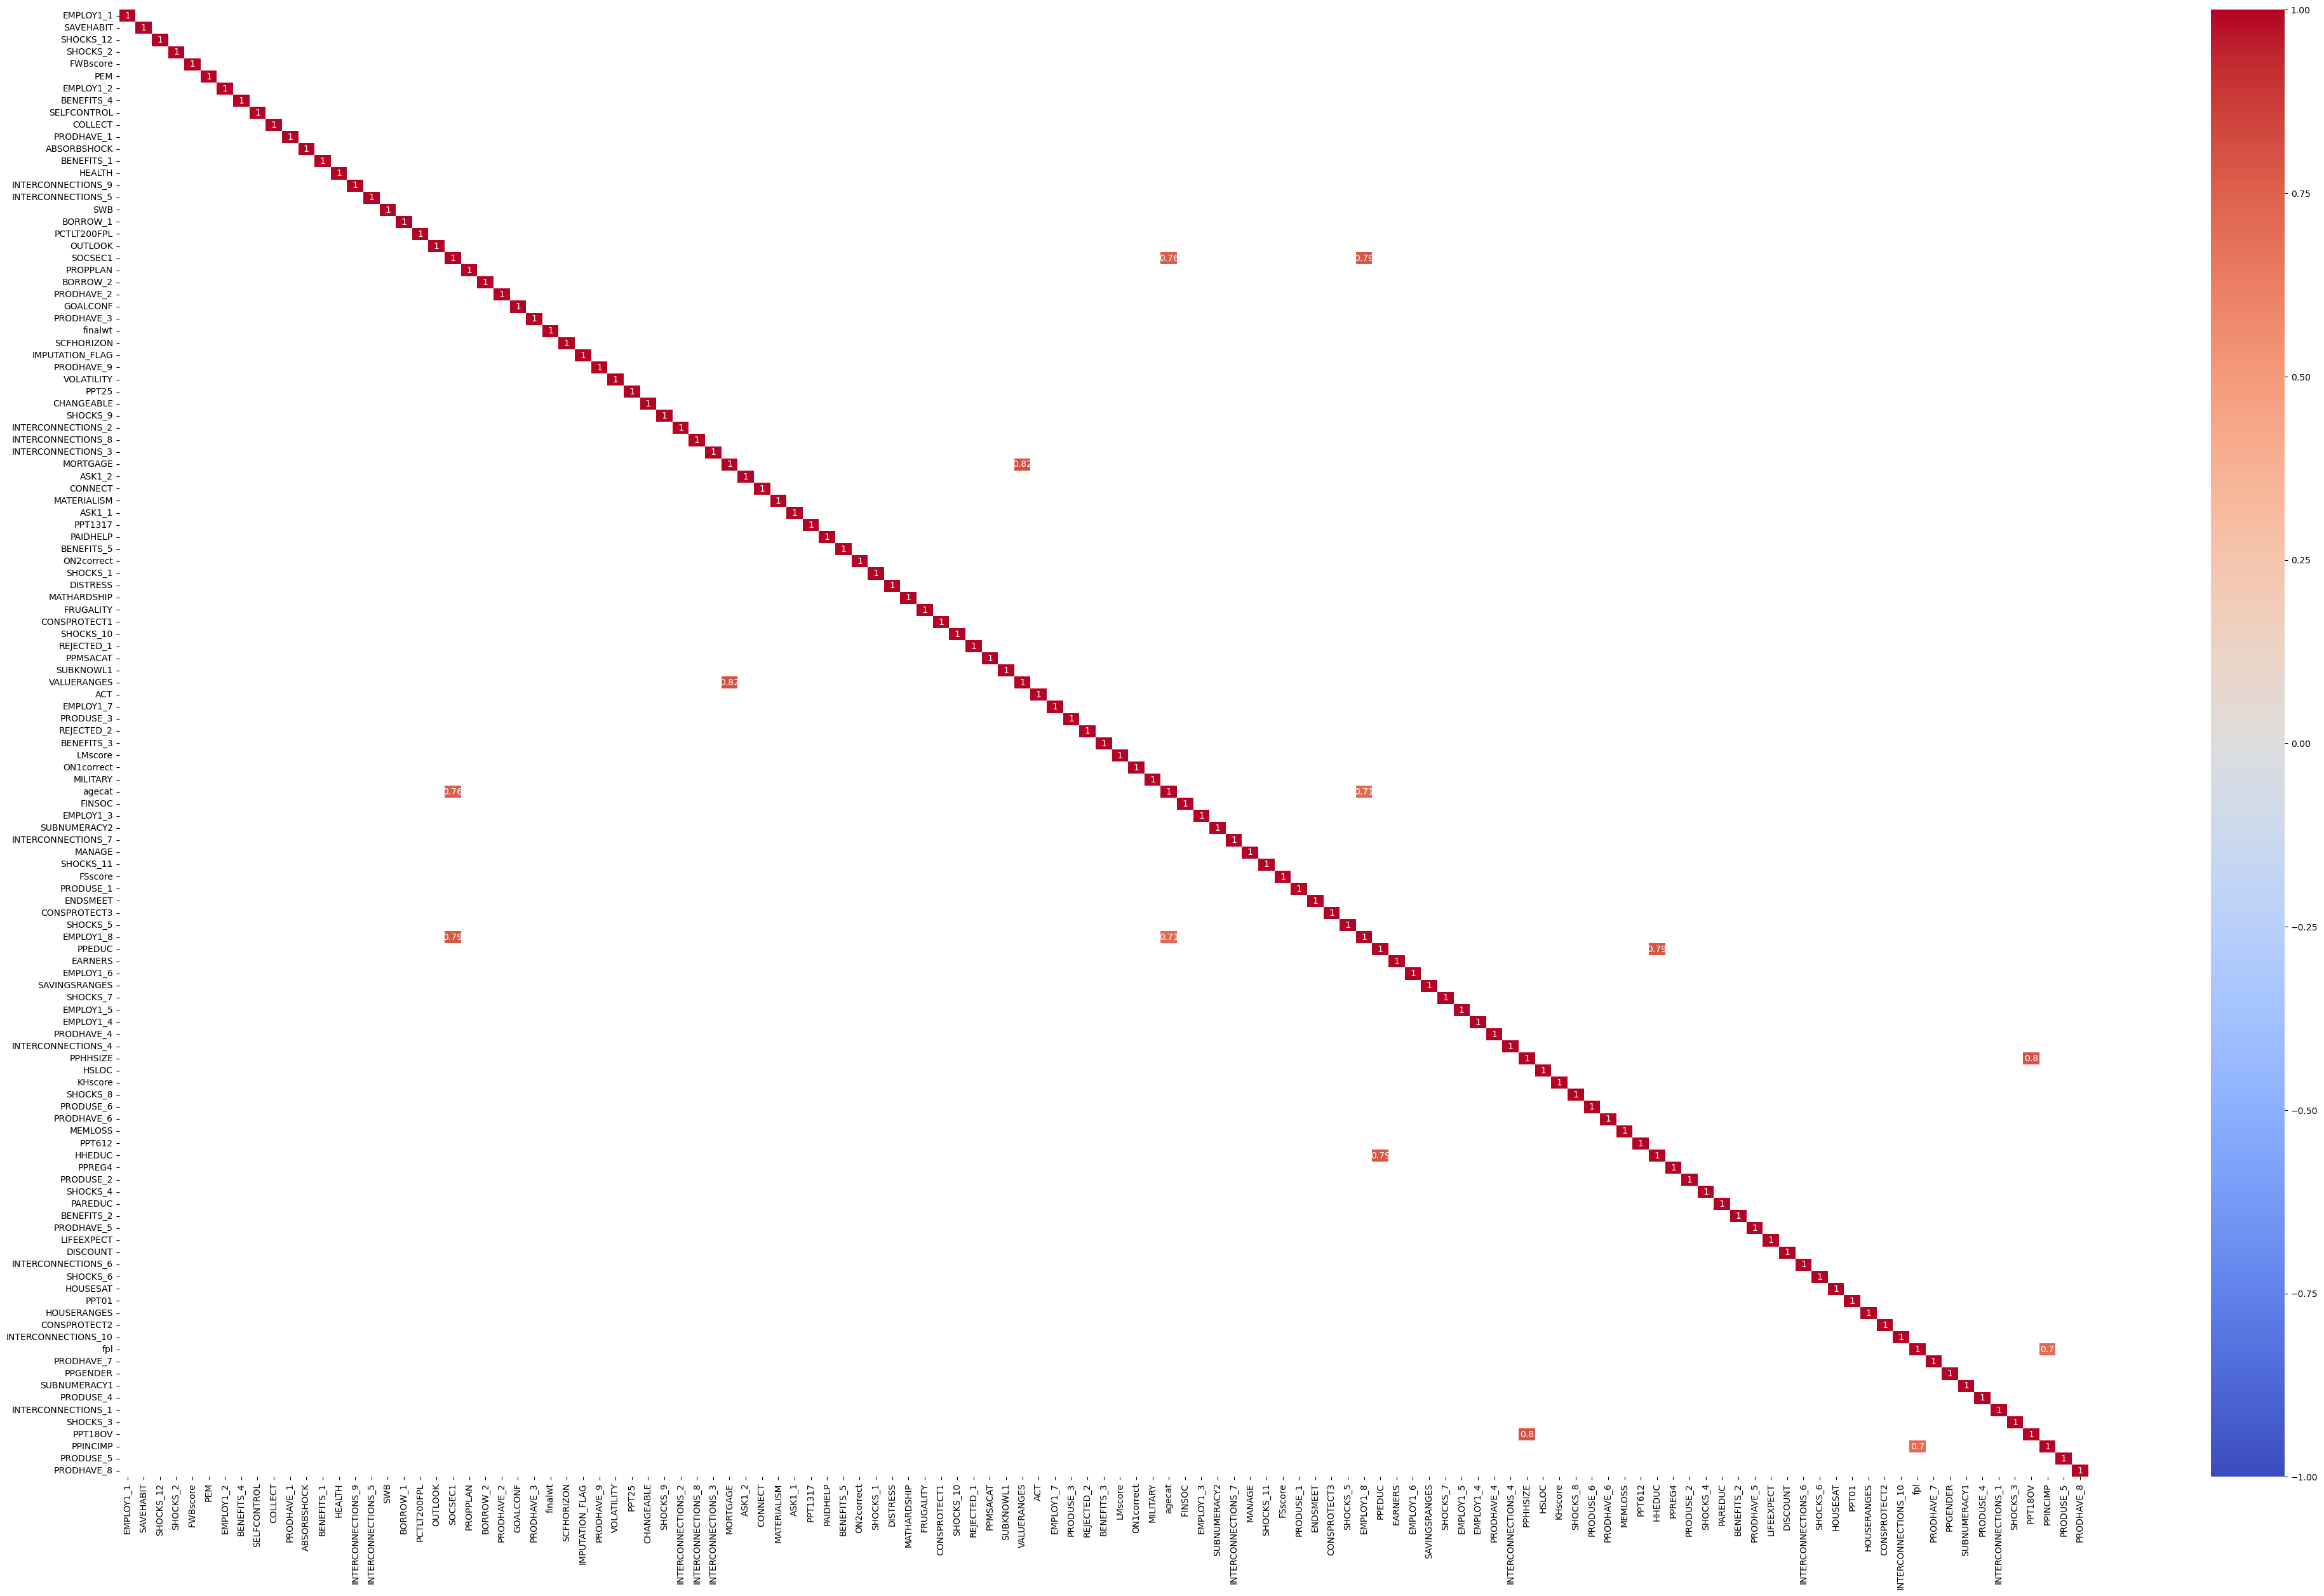

In [41]:
# sns heatmap with annot and only on one side of the diagonal and only on correlations above 0.7
plt.figure(figsize = (50, 30))
sns.heatmap(data_engineered[num_feats].corr(method = 'spearman')[data_engineered[num_feats].corr(method = 'spearman') > 0.7].dropna(how = 'all').dropna(how = 'all', axis = 1), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

In [42]:
# get pairs of features with correelation above 0.7
corr = data_engineered[num_feats].corr(method = 'spearman')
corr[corr > 0.7].notna().sum()[corr[corr > 0.7].notna().sum() > 1] # columns that are highly correlated with others

SOCSEC1        3
MORTGAGE       2
VALUERANGES    2
agecat         3
EMPLOY1_8      3
PPEDUC         2
PPHHSIZE       2
HHEDUC         2
fpl            2
PPT18OV        2
PPINCIMP       2
dtype: int64

Let's remove SOCSEC1 because it is highly correlated with both agecat and EMPLOY_8

VALUERANGES is HIGHLY correlated with MORTGAGE

In [43]:
data_engineered.corr(method = 'spearman')['MORTGAGE'].mean()

0.046711227015447

In [44]:
data_engineered.corr(method = 'spearman')['VALUERANGES'].mean()

0.05193523193114918

Let's remove VALUERANGES because ir has higher correlation with the overall variables

PPHHSIZE and PPT18OV are also highly correlated

Given we have variables PPT01 ... PPT1317, if all of them are set to 0 we know that there are no children. If there are no children, the variable PPT18OV and the variable PPHHSIZE are going to have the same value. Therefore, PPT18OV becomes useless. Let's remove it.

PPHEDUC and HHEDUC are also highly correlated. It is probably more important to know to level of education of the respondant rather than the highest level of education of all household members.

In [45]:
data_feat_selection = data_engineered.copy()

data_feat_selection.drop(['SOCSEC1', 'VALUERANGES', 'HHEDUC', 'PPT18OV'], axis = 1, inplace = True)

In [46]:
data_feat_selection.shape

(6078, 132)

In [47]:
data_feat_selection.to_csv('data/data_feat_selection.csv')

## Recursive Feature Elimination

We have 162 features. I want to keep only 80.

In [60]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [49]:
X = data_feat_selection.drop('fpl', axis = 1)
Y = data_feat_selection['fpl']

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

In [51]:
X_train_sample_weights = X_train['finalwt']
X_train.drop('finalwt', axis = 1, inplace = True)
X_val_sample_weights = X_val['finalwt']
X_val.drop('finalwt', axis = 1, inplace = True)

In [52]:
class_weights = compute_class_weight('balanced', classes=[1, 2, 3], y=y_train)
weights = {}
for i, value in enumerate(class_weights):
    weights[i + 1] = value

In [53]:
weights

{1: 3.3623789764868603, 2: 2.5283411336453456, 3: 0.4334492288490684}

In [54]:
X_train_weights = y_train.map({k: v for k, v in weights.items()})
X_val_weights = y_val.map({k: v for k, v in weights.items()})

In [81]:
def rfe_selection(X_train, y_train, X_val, y_val, min_feats, tol):
  """
    Function that selects the K most important features according to RFE.
    The k is dinamically choosen by calculating the scores of the model with values of K ranging from 1 to the number of features.
  """
  nr_features_list = list(range(min_feats, len(X_train.columns) +1))
  highest_score=0

  # to select the best nr of features to keep
  for n in nr_features_list:
    # create model for the RFE to use
    model = DecisionTreeClassifier(random_state = 20)

    # create RFE object to select the best n features
    rfe = RFE(estimator = model, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train, y_train, sample_weight = X_train_sample_weights)
    X_val_rfe = rfe.transform(X_val)

    # fit the model with the selected features
    model.fit(X_train_rfe, y_train, sample_weight = X_train_sample_weights)
    
    # model score
    y_pred = model.predict(X_val_rfe)
    score = f1_score(y_val, y_pred, average = 'weighted')
    print(score)

    # select the number of features that show the highest score
    if(score > (highest_score + tol)):
      selected_features = X_train.columns[rfe.support_].values
      highest_score = score

  return selected_features

In [82]:
sel_features = rfe_selection(X_train, y_train, X_val, y_val, min_feats = 80, tol = 0.01)

0.9551449580061822


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [78]:
sel_features

array(['FWBscore', 'FSscore', 'SUBKNOWL1', 'FINGOALS', 'SAVEHABIT',
       'FRUGALITY', 'AUTOMATED_1', 'AUTOMATED_2', 'ASK1_1', 'ASK1_2',
       'SUBNUMERACY2', 'SUBNUMERACY1', 'CHANGEABLE', 'GOALCONF',
       'LMscore', 'KHscore', 'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT',
       'HOUSERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'PRODHAVE_1',
       'PRODHAVE_2', 'PRODHAVE_3', 'PRODHAVE_4', 'PRODHAVE_5',
       'PRODHAVE_6', 'PRODHAVE_8', 'PRODUSE_3', 'PRODUSE_5', 'PRODUSE_6',
       'CONSPROTECT2', 'EARNERS', 'VOLATILITY', 'SNAP', 'ABSORBSHOCK',
       'FRAUD2', 'COVERCOSTS', 'BORROW_2', 'SHOCKS_10', 'PAREDUC',
       'ON2correct', 'ON1correct', 'CONNECT', 'HEALTH', 'SCFHORIZON',
       'DISCOUNT', 'DISTRESS', 'INTERCONNECTIONS_1', 'INTERCONNECTIONS_2',
       'INTERCONNECTIONS_3', 'INTERCONNECTIONS_4', 'INTERCONNECTIONS_7',
       'INTERCONNECTIONS_9', 'INTERCONNECTIONS_10', 'PEM', 'HOUSESAT',
       'EMPLOY1_1', 'EMPLOY1_2', 'EMPLOY1_3', 'EMPLOY1_4', 'EMPLOY1_5',
       'EMPLOY1_8', 'ag

In [79]:
set(X_train.columns) - set(sel_features)

{'BENEFITS_1',
 'BENEFITS_2',
 'BENEFITS_3',
 'BENEFITS_4',
 'BENEFITS_5',
 'BORROW_1',
 'COLLECT',
 'CONSPROTECT1',
 'CONSPROTECT3',
 'EMPLOY1_6',
 'EMPLOY1_7',
 'HSLOC',
 'IMPUTATION_FLAG',
 'INTERCONNECTIONS_5',
 'INTERCONNECTIONS_6',
 'INTERCONNECTIONS_8',
 'LIFEEXPECT',
 'MANAGE',
 'MANAGE2',
 'MEMLOSS',
 'MILITARY',
 'OUTLOOK',
 'PAIDHELP',
 'PPMSACAT',
 'PPREG9',
 'PPT01',
 'PPT1317',
 'PPT612',
 'PRODHAVE_7',
 'PRODHAVE_9',
 'PRODUSE_1',
 'PRODUSE_2',
 'PRODUSE_4',
 'REJECTED_1',
 'REJECTED_2',
 'RETIRE',
 'SELFCONTROL',
 'SHOCKS_1',
 'SHOCKS_11',
 'SHOCKS_12',
 'SHOCKS_2',
 'SHOCKS_3',
 'SHOCKS_4',
 'SHOCKS_5',
 'SHOCKS_6',
 'SHOCKS_7',
 'SHOCKS_8',
 'SHOCKS_9',
 'generation',
 'sample'}

In [80]:
len(sel_features)

80

In [68]:
len(X_train.columns)

130